In [197]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from prettytable import Prettytable

ModuleNotFoundError: No module named 'prettytable'

In [178]:
dev_df= pd.read_csv("development.csv", index_col=0)
eval_df= pd.read_csv("evaluation.csv", index_col=0)

In [179]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2933 entries, 0 to 2932
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sampling_rate           2933 non-null   int64  
 1   age                     2933 non-null   float64
 2   gender                  2933 non-null   object 
 3   ethnicity               2933 non-null   object 
 4   mean_pitch              2933 non-null   float64
 5   max_pitch               2933 non-null   float64
 6   min_pitch               2933 non-null   float64
 7   jitter                  2933 non-null   float64
 8   shimmer                 2933 non-null   float64
 9   energy                  2933 non-null   float64
 10  zcr_mean                2933 non-null   float64
 11  spectral_centroid_mean  2933 non-null   float64
 12  tempo                   2933 non-null   object 
 13  hnr                     2933 non-null   float64
 14  num_words               2933 non-null   int64

In [180]:
dev_df.drop(columns=["ethnicity", "path"], inplace=True)

In [181]:
dev_df.isna().sum()

sampling_rate             0
age                       0
gender                    0
mean_pitch                0
max_pitch                 0
min_pitch                 0
jitter                    0
shimmer                   0
energy                    0
zcr_mean                  0
spectral_centroid_mean    0
tempo                     0
hnr                       0
num_words                 0
num_characters            0
num_pauses                0
silence_duration          0
dtype: int64

In [182]:
dev_df["tempo"] = dev_df["tempo"].apply(lambda x: float(x.strip("[]")))

In [183]:
# vogliamo rimpiazzare male:1 e female:1 // USa one hot encoding
dev_df["gender"] = np.where(dev_df["gender"]=="male", 0,1)

In [184]:
std=StandardScaler()
dev_std=pd.DataFrame(std.fit_transform(dev_df), columns=dev_df.columns)
mm=MinMaxScaler()
dev_mm=pd.DataFrame(mm.fit_transform(dev_df), columns=dev_df.columns)

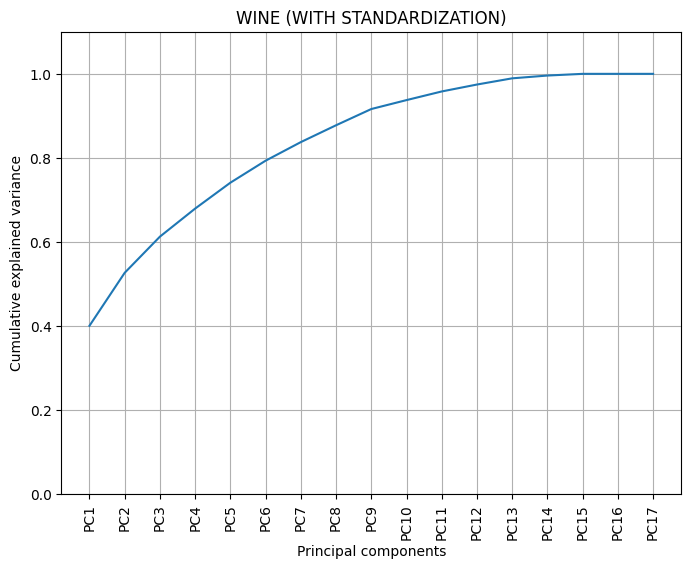

In [ ]:
pca= PCA()
pca.fit(dev_std.values)

round_expl_var_ratio = np.round(pca.explained_variance_ratio_.sum()*100,decimals=2)  # <-- TODO!!

plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('WINE (WITH STANDARDIZATION)')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca.n_features_in_), 
           labels=[f'PC{i + 1}' for i in range(pca.n_features_in_)],
           rotation=90)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.ylim()
plt.grid()
plt.show()

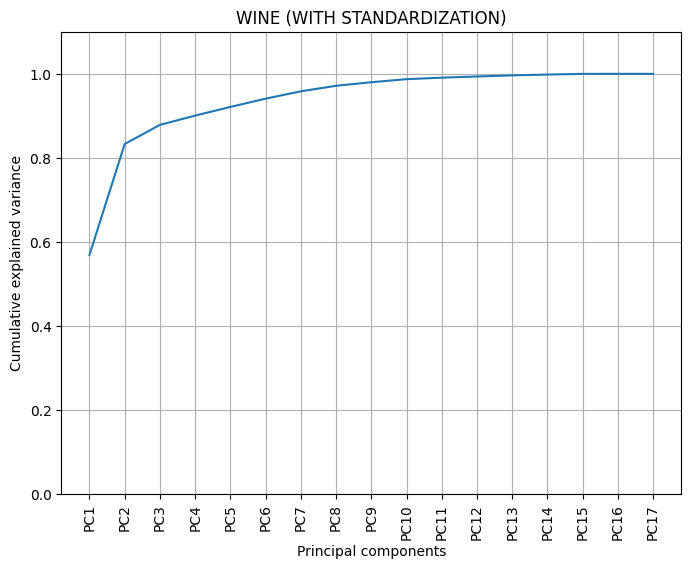

In [186]:
pca= PCA()
pca.fit(dev_mm.values)

round_expl_var_ratio = np.round(pca.explained_variance_ratio_.sum()*100,decimals=2)  # <-- TODO!!

plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('WINE (WITH STANDARDIZATION)')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca.n_features_in_), 
           labels=[f'PC{i + 1}' for i in range(pca.n_features_in_)],
           rotation=90)
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.ylim()
plt.grid()
plt.show()

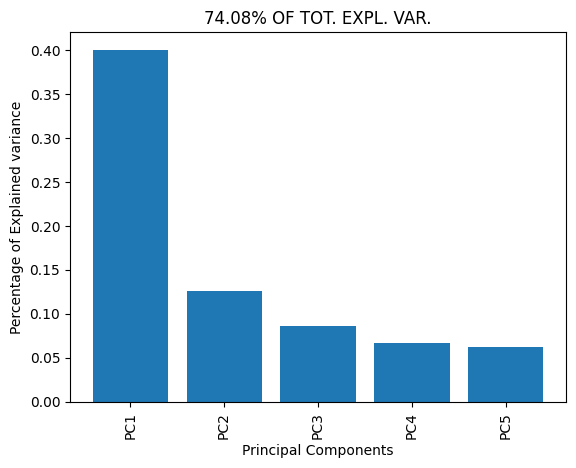

In [ ]:
m=5
pca_std = PCA(n_components=m)
pca_std.fit(dev_std)  
round_expl_var_ratio = np.round(pca_std.explained_variance_ratio_.sum()*100,decimals=2)

plt.figure()
plt.bar(range(1,m+1), pca_std.explained_variance_ratio_)
plt.title(f"{round_expl_var_ratio}% OF TOT. EXPL. VAR.")
plt.xticks(ticks=np.arange(1,m+1), 
           labels=[f"PC{i}" for i in range(1,m+1)],
           rotation=90)
plt.xlabel("Principal Components")
plt.ylabel("Percentage of Explained variance")
plt.show()

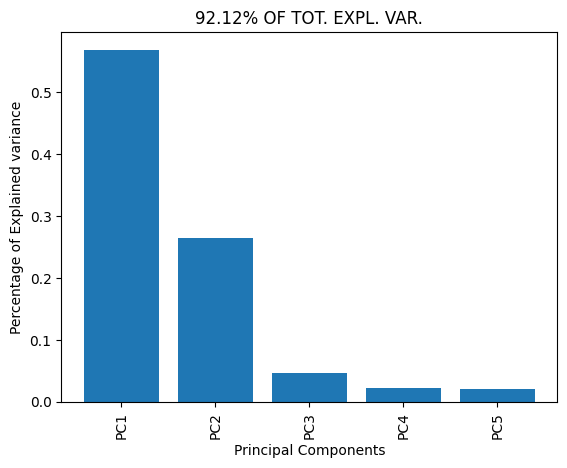

In [188]:
m= 5
pca_std = PCA(n_components=m)
pca_std.fit(dev_mm)  
round_expl_var_ratio = np.round(pca_std.explained_variance_ratio_.sum()*100,decimals=2)

plt.figure()
plt.bar(range(1,m+1), pca_std.explained_variance_ratio_)
plt.title(f"{round_expl_var_ratio}% OF TOT. EXPL. VAR.")
plt.xticks(ticks=np.arange(1,m+1), 
           labels=[f"PC{i}" for i in range(1,m+1)],
           rotation=90)
plt.xlabel("Principal Components")
plt.ylabel("Percentage of Explained variance")
plt.show()

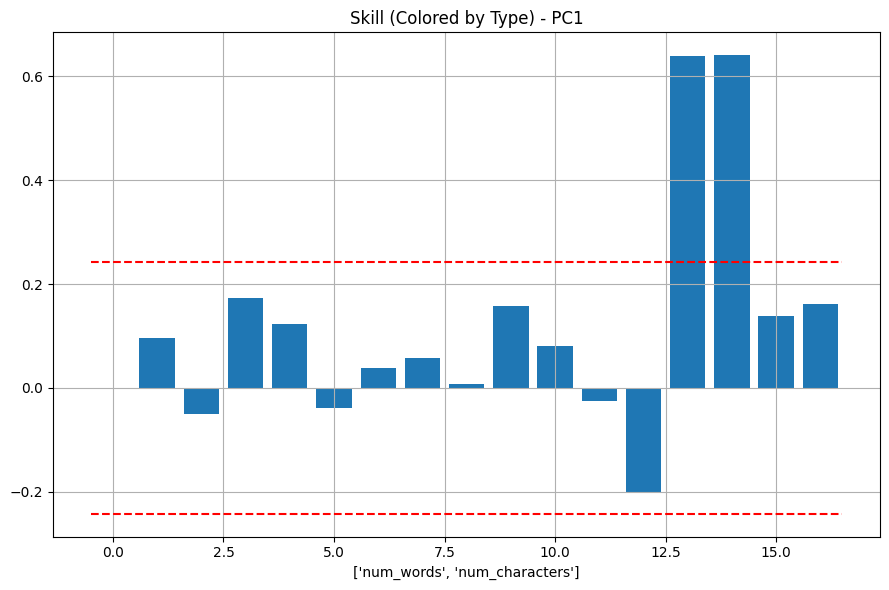


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['num_words', 'num_characters']

HIGH-VALUED NEGATIVE COMPONENTS: []
*********************************************



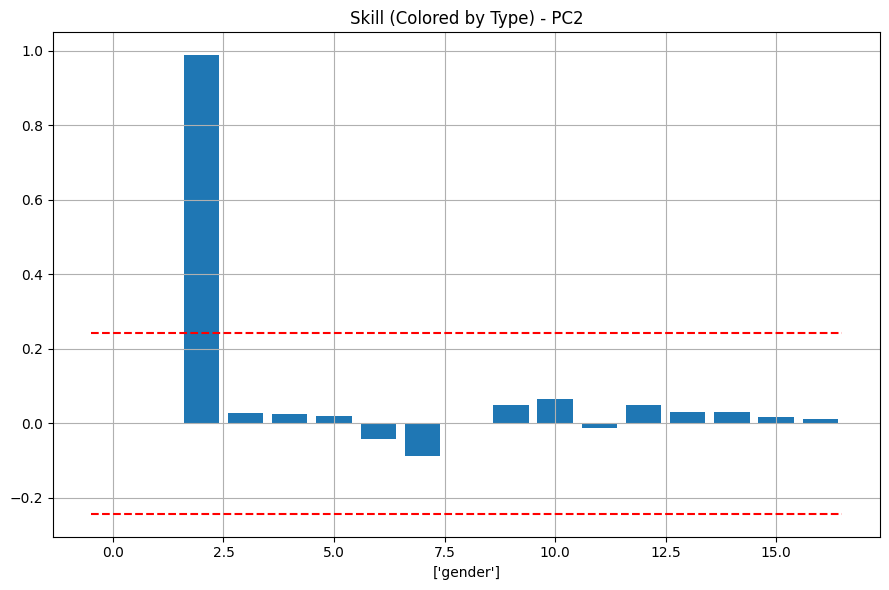


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['gender']

HIGH-VALUED NEGATIVE COMPONENTS: []
*********************************************



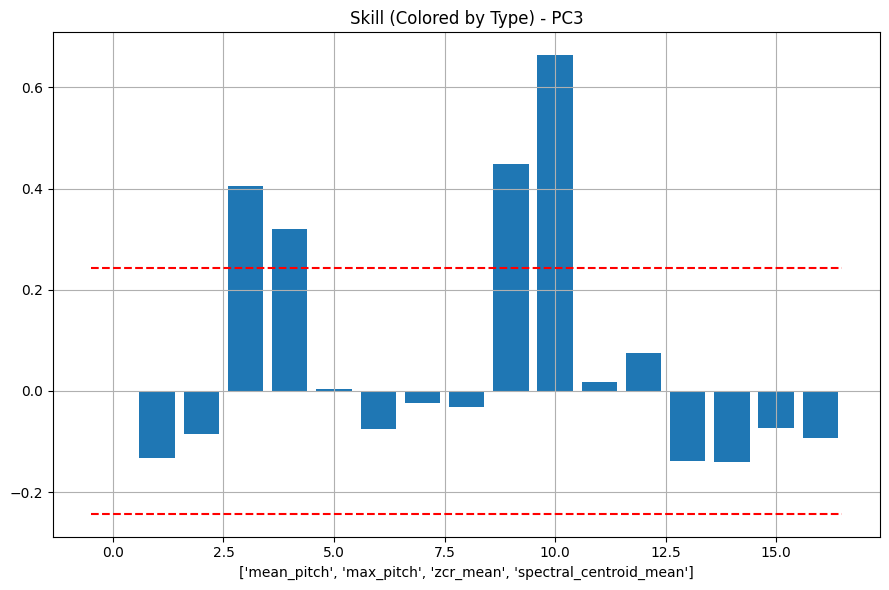


****************** PC3 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['mean_pitch', 'max_pitch', 'zcr_mean', 'spectral_centroid_mean']

HIGH-VALUED NEGATIVE COMPONENTS: []
*********************************************



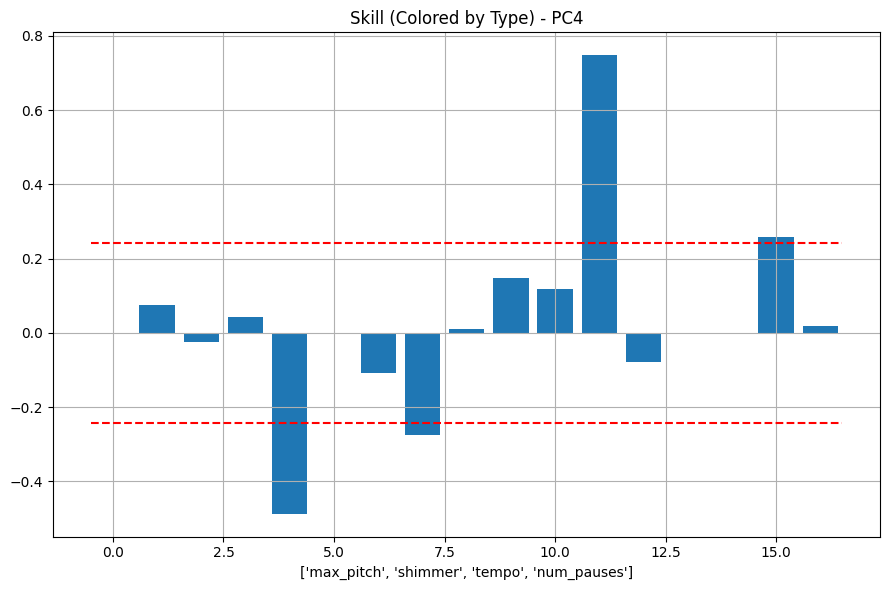


****************** PC4 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['tempo', 'num_pauses']

HIGH-VALUED NEGATIVE COMPONENTS: ['max_pitch', 'shimmer']
*********************************************



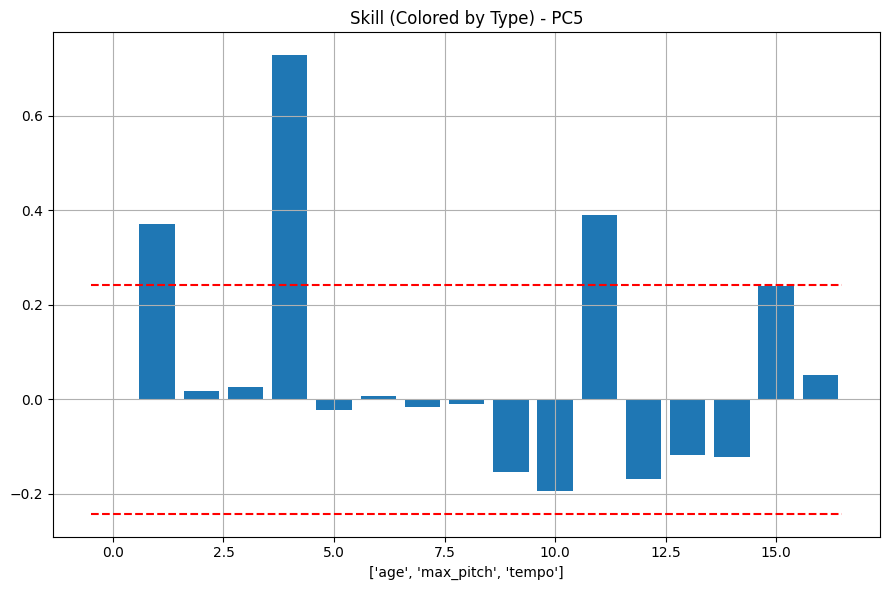


****************** PC5 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['age', 'max_pitch', 'tempo']

HIGH-VALUED NEGATIVE COMPONENTS: []
*********************************************



In [ ]:
# Calcolo di epsilon
eps = np.sqrt(1 / pca_std.n_features_in_)

# Lista delle colonne
cols = dev_mm.columns.to_list()

# Ciclo per ogni componente principale
for ii in range(m):
    # Indici di componenti maggiori o uguali a epsilon (positivo e negativo)
    ind_great_pos_PCii = np.where(pca_std.components_[ii, :] >= eps)[0]
    ind_great_neg_PCii = np.where(pca_std.components_[ii, :] <= -eps)[0]
    ind_significant = np.union1d(ind_great_pos_PCii, ind_great_neg_PCii)  # Unione degli indici

    # Estrarre i label significativi
    significant_labels = [cols[idx] for idx in ind_significant]
    significant_values = pca_std.components_[ii, ind_significant]


    
    # Creazione del barplot
    plt.figure(figsize=(9, 6))
    #tupl= sorted(zip(ind_significant, significant_values), reverse=True, key=lambda x: x[1]) 
    plt.bar(np.arange(pca_std.n_features_in_), pca_std.components_[ii,:])
    plt.plot([-0.5, len(cols) - 0.5], [eps, eps], "red", linestyle="--", label=r"$\epsilon$")
    plt.plot([-0.5, len(cols) - 0.5], [-eps, -eps], "red", linestyle="--")
    plt.xlabel(significant_labels)
    plt.title(f"Skill (Colored by Type) - PC{ii + 1}")
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    great_pos_PCii= [pca_std.feature_names_in_[i] for i in ind_great_pos_PCii]    
    great_neg_PCii= [pca_std.feature_names_in_[i] for i in ind_great_neg_PCii]
        
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')  # <-- TODO!!
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')  # <-- TODO!!
    print('*********************************************')
    print('')


In [192]:
models=[
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(),
    MLPRegressor(hidden_layer_sizes=(10,), random_state=42, max_iter=10000),
    MLPRegressor(hidden_layer_sizes=(10,10),  activation='tanh', solver='lbfgs',
                 alpha=0.000, batch_size='auto', learning_rate='constant',
                 learning_rate_init=0.01, power_t=0.5, max_iter=10000, shuffle=True,
                 random_state=42, tol=0.0001, verbose=True, warm_start=False,
                 momentum=0.0, nesterovs_momentum=False, early_stopping=False,
                 validation_fraction=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    SVR(gamma="scale"),
    RandomForestRegressor(n_estimators=300),
    DecisionTreeRegressor()
]


names=[
    'linreg',
    'ridge',
    "lasso",
    'mlp_standard',
    'mlp_tuned',
    'svr',
    'Random Forest',
    "Decision Tree"
]

In [ ]:
f